<a href="https://colab.research.google.com/github/ralfcam/LANL-Earthquake-Prediction/blob/master/LANL_Earthquake_with_H2O_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# !pip install kaggle
!mkdir .kaggle

In [0]:
import json
import os

token = {"username":"","key":""}

os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json

# !kaggle datasets list

- path is now set to: {/content}


In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction -p /content

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 57.1MB/s]
100% 241M/242M [00:02<00:00, 87.6MB/s]
100% 242M/242M [00:02<00:00, 92.4MB/s]
 99% 2.02G/2.03G [00:33<00:00, 70.9MB/s]
100% 2.03G/2.03G [00:33<00:00, 65.2MB/s]


In [0]:
!unzip \*.zip

In [0]:
import numpy as np
import pandas as pd

In [0]:
%%time
train = pd.read_csv('/content/train.csv', dtype={'acoustic_data': np.int16,
                                                 'time_to_failure': np.float32})

CPU times: user 2min 3s, sys: 33.3 s, total: 2min 36s
Wall time: 2min 46s


In [0]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:
train.shape

(629145480, 2)

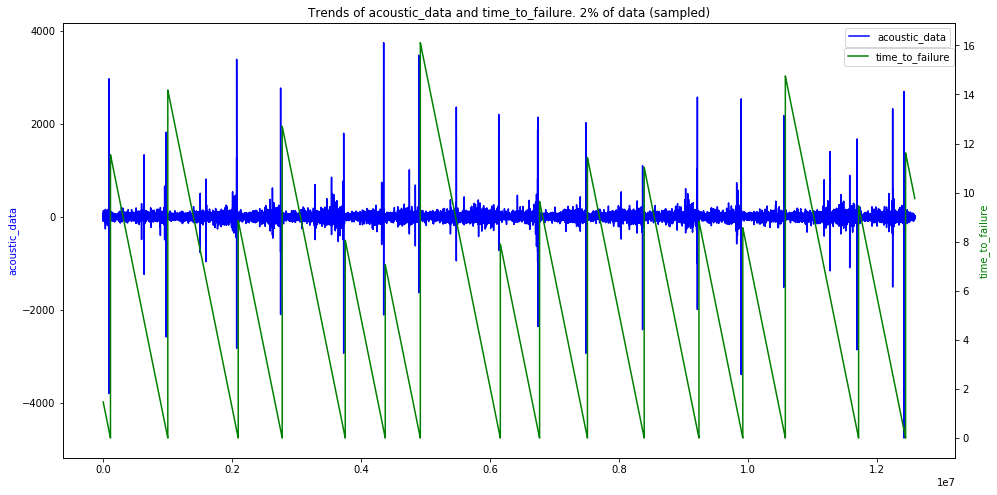

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

# Andrews Features Only

In [0]:
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.signal import hilbert, convolve, hann

# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [0]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4194 samples in new train data and 138 columns.


In [0]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100     0.648824
q01_roll_std_100     0.644797
q05_roll_std_10      0.643123
q01_roll_std_10      0.635264
q05_roll_std_1000    0.614482
q01_roll_std_1000    0.603691
min_roll_std_1000    0.544294
iqr                  0.506994
q95_roll_std_10      0.439754
q95_roll_mean_10     0.439483
q95_roll_std_100     0.433792
q05_roll_mean_10     0.428967
dtype: float64

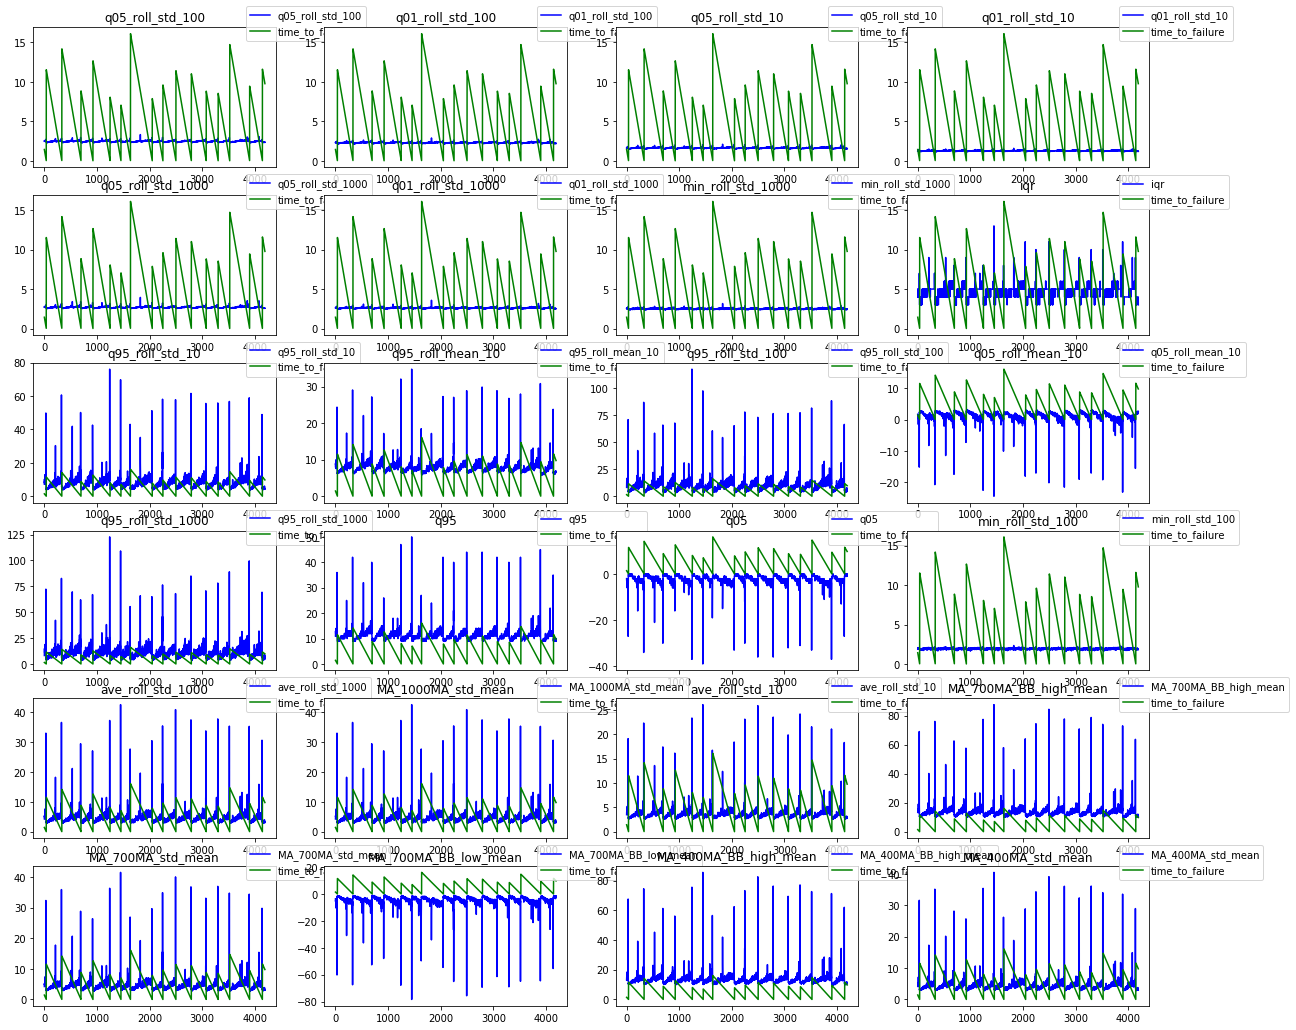

In [0]:
plt.figure(figsize=(20, 18))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

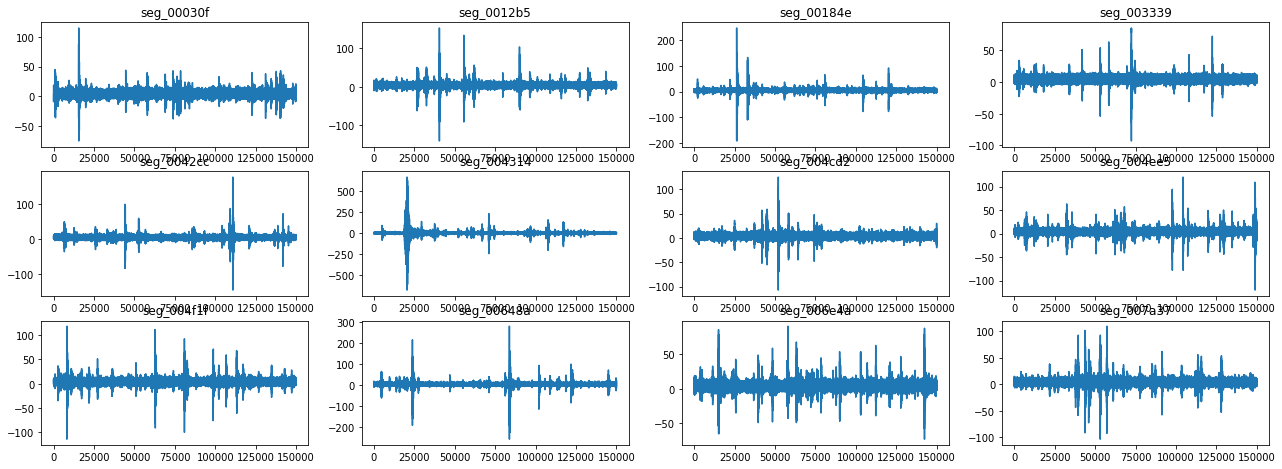

In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv(seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

In [0]:
# X_tr.head()
# X_test.head()
X_tr.shape

(4194, 138)

In [0]:
X_tr.to_csv('X_tr.csv', index=False)
y_tr.to_csv('y_tr.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# LANL Earthquake with H2O AutoML

In [0]:
!pip install h2o

     |████████████████████████████████| 121.8MB 161kB/s 
  Stored in directory: /root/.cache/pip/wheels/36/73/57/2ea67a8a35ea9114f7d66cc8c5ec46c915698c909321f8a17d
Successfully built h2o


In [0]:
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init() # max_mem_size='16G'

3.24.0.3
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqpcn64ay
  JVM stdout: /tmp/tmpqpcn64ay/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqpcn64ay/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,"14 days, 5 hours and 19 minutes"
H2O cluster name:,H2O_from_python_unknownUser_a6wgtc
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
train = h2o.import_file("X_tr.csv")
test = h2o.import_file("X_test.csv")
y_train = h2o.import_file("y_tr.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train.head()

mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,mean_change_rate_first_50000,mean_change_rate_last_50000,mean_change_rate_first_10000,mean_change_rate_last_10000,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,trend,abs_trend,abs_mean,abs_std,mad,kurt,skew,med,Hilbert_mean,Hann_window_mean,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,Moving_average_700_mean,Moving_average_1500_mean,Moving_average_3000_mean,Moving_average_6000_mean,exp_Moving_average_300_mean,exp_Moving_average_3000_mean,exp_Moving_average_30000_mean,MA_700MA_std_mean,MA_700MA_BB_high_mean,MA_700MA_BB_low_mean,MA_400MA_std_mean,MA_400MA_BB_high_mean,MA_400MA_BB_low_mean,MA_1000MA_std_mean,iqr,q999,q001,ave10,ave_roll_std_10,std_roll_std_10,max_roll_std_10,min_roll_std_10,q01_roll_std_10,q05_roll_std_10,q95_roll_std_10,q99_roll_std_10,av_change_abs_roll_std_10,av_change_rate_roll_std_10,abs_max_roll_std_10,ave_roll_mean_10,std_roll_mean_10,max_roll_mean_10,min_roll_mean_10,q01_roll_mean_10,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,av_change_abs_roll_mean_10,av_change_rate_roll_mean_10,abs_max_roll_mean_10,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
4.88411,5.10111,104,-98,-8.00005e-05,74836.6,104,0,6.48855,3.66466,11.2072,4.36141,4.9621,4.62046,5.182,4.6756,-98,-21,-98,-16,104,30,104,26,1.06122,6,0,732617,24942.3,25002.3,4981.15,4983.58,11,18,-2,-8,12,20,1,0,-3.2683e-06,-1.12785e-05,5.57657,4.33332,3.2634,33.6625,-0.0240612,5,7.02703,4.88333,0.920976,0.266087,0.935911,0.808124,4.88359,4.88267,4.8805,4.87777,4.88465,4.88735,4.89181,4.22942,13.3424,-3.57524,4.15581,13.1952,-3.42802,4.28859,4,40,-30,4.86934,3.50712,2.80907,78.313,0.421637,1.26491,1.63639,7.22649,15.0342,-1.53422e-06,74731,78.313,4.88409,2.8018,68.5,-60,-2.4,1.7,8.1,12.4,-1.13341e-05,74736.7,68.5,4.05045,3.11152,52.3353,1.93542,2.30263,2.47564,8.1959,16.9488,-5.23545e-06,74759.6,52.3353,4.88386,0.452294,10.04,1.04,3.81,4.16,5.58,5.95,-2.4016e-06,74760.1,10.04,4.28859,2.76977,31.0294,2.53663,2.61609,2.70647,8.18576,15.056,-1.17955e-05,74223.6,31.0294,4.88342,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-1.7047e-06,74222.3,5.629
4.72577,6.58882,181,-154,0,74891.7,181,0,7.30523,5.49307,3.97675,3.66789,4.6984,4.78834,4.7772,4.9144,-154,-115,-23,-24,181,111,29,29,1.17532,27,0,708865,25027.3,24957.8,4990.56,4978.31,12,21,-2,-11,12,24,1,0,9.09042e-07,-5.38941e-06,5.73417,5.73278,3.5743,98.7585,0.390561,5,7.38038,4.72505,0.965946,0.285984,0.948883,0.79155,4.72482,4.72491,4.72367,4.7182,4.72605,4.72803,4.72762,4.73535,14.1955,-4.74589,4.60858,13.942,-4.49234,4.84349,5,59,-47,4.7242,3.76143,4.12078,122.978,0.421637,1.28668,1.64655,8.26573,18.7727,-3.28446e-06,74835.4,122.978,4.72573,3.92407,145.1,-128,-4.6,1.2,8.2,13.8,2.66684e-06,74828.6,145.1,4.43636,4.89343,87.9726,1.99137,2.30029,2.47597,9.82992,23.4573,-4.87196e-07,74802

In [0]:
train['time_to_failure'] = y_train['time_to_failure']

In [0]:
%%time
train['time_to_failure'] = y_train['time_to_failure']
x = test.columns
y = 'time_to_failure'

aml = H2OAutoML(max_models=100, max_runtime_secs=3600, stopping_metric='MAE') # seed=33,
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 10.3 s, sys: 1.08 s, total: 11.4 s
Wall time: 46min 14s


In [0]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_20190521_101044_model_9,7.04533,2.6543,7.04533,2.0712,0.510846
GBM_grid_1_AutoML_20190521_084240_model_29,7.06034,2.65713,7.06034,2.0784,0.512125
GBM_grid_1_AutoML_20190521_101044_model_12,7.06723,2.65843,7.06723,2.07569,0.5129
GBM_grid_1_AutoML_20190521_084240_model_53,7.0928,2.66323,7.0928,2.06949,0.510405
GBM_grid_1_AutoML_20190521_084240_model_14,7.09696,2.66401,7.09696,2.0739,0.510519
GBM_5_AutoML_20190521_101044,7.1001,2.6646,7.1001,2.07294,0.510387
GBM_grid_1_AutoML_20190521_084240_model_17,7.11195,2.66682,7.11195,2.07862,0.511922
XGBoost_grid_1_AutoML_20190521_084240_model_8,7.12039,2.66841,7.12039,2.06507,0.507323
GBM_5_AutoML_20190521_084240,7.12392,2.66907,7.12392,2.07954,0.511664
XGBoost_3_AutoML_20190521_084240,7.1484,2.67365,7.1484,2.06226,0.506703


In [0]:
# The leader model is stored here
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190521_101044_model_9


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5.839327202282622
RMSE: 2.4164699878712796
MAE: 1.8806869073605061
RMSLE: 0.47686789177031974
Mean Residual Deviance: 5.839327202282622

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 7.0453328853967845
RMSE: 2.6543045954443105
MAE: 2.0711995847559312
RMSLE: 0.5108457084454961
Mean Residual Deviance: 7.0453328853967845
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2.071201,0.0140208,2.0364754,2.0638592,2.084558,2.0931556,2.0779574
mean_residual_deviance,7.0453534,0.0635008,6.8727474,7.075518,7.0904613,7.0562754,7.131765
mse,7.0453534,0.0635008,6.8727474,7.075518,7.0904613,7.0562754,7.131765
r2,0.47767,0.0050291,0.4910830,0.4762091,0.4715489,0.4776193,0.4718898
residual_deviance,7.0453534,0.0635008,6.8727474,7.075518,7.0904613,7.0562754,7.131765
rmse,2.6542542,0.0120087,2.6215925,2.6599846,2.662792,2.6563652,2.6705365
rmsle,0.5107755,0.0061049,0.4998769,0.5164882,0.514052,0.5015141,0.5219459


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-05-21 10:27:10,4 min 22.880 sec,0.0,3.6727069,3.0480839,13.4887759
,2019-05-21 10:27:10,4 min 23.050 sec,5.0,3.2817193,2.6857614,10.7696817
,2019-05-21 10:27:10,4 min 23.228 sec,10.0,3.0155625,2.4378020,9.0936172
,2019-05-21 10:27:10,4 min 23.397 sec,15.0,2.8380359,2.2718323,8.0544478
,2019-05-21 10:27:11,4 min 23.571 sec,20.0,2.7194687,2.1637489,7.3955102
,2019-05-21 10:27:11,4 min 23.767 sec,25.0,2.6370053,2.0884801,6.9537968
,2019-05-21 10:27:11,4 min 23.944 sec,30.0,2.5789197,2.0335114,6.6508268
,2019-05-21 10:27:11,4 min 24.131 sec,35.0,2.5372449,1.9943987,6.4376115
,2019-05-21 10:27:11,4 min 24.321 sec,40.0,2.5030146,1.9626128,6.2650823
,2019-05-21 10:27:12,4 min 24.502 sec,45.0,2.4771044,1.9370368,6.1360464


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
q05_roll_std_100,144172.2656250,1.0,0.4499418
q05_roll_std_10,82245.4453125,0.5704665,0.2566767
q05_roll_std_1000,19573.0585938,0.1357616,0.0610848
q01_roll_std_10,10541.9208984,0.0731203,0.0328999
MA_400MA_BB_high_mean,6694.9091797,0.0464369,0.0208939
---,---,---,---
q01,6.7769408,0.0000470,0.0000211
min,0.0,0.0,0.0
count_big,0.0,0.0,0.0
abs_q05,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [0]:
preds = aml.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [0]:
preds = aml.predict(test)

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['time_to_failure'] = preds.as_data_frame().values.flatten()
sample_submission.to_csv('submission_aml.csv', index=False)

!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "h2o_submission_exfeat" 

In [0]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "h2o_submission2" 

100% 74.8k/74.8k [00:03<00:00, 20.6kB/s]
Successfully submitted to LANL Earthquake Prediction